In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, ifft, fftshift, fftn,ifftn
pi=np.pi

## Filtering in a simple example

The challenge in applying fitlers to read data is the noise. The DFT offers many amazing ways to manipulate data, but in the precense of noise we have to be careful to filter the data as well. Let's start by applying this to a simple example:

$$ s =3\cos(4 t^{1/2})$$

In [2]:
t=np.arange(0,6*pi,6*pi/300) # delta t =6pi/300
omega=np.arange(-50,50,1/3)  # delta w = 2pi/(6pi) = 1/2, wnquist = pi/delta t = 300/6= 50
rawsig=3*np.cos(4*t**(1/2))

Now we want to include a kernel that convolved with the data so that it is smoothed out:

$$ \tilde f(\omega) = \tilde s(\omega) e^{-(0.02\omega)^2}$$

In [3]:
sfft=fft(rawsig)*np.exp(-(2e-2*omega)**2)
smoothed=np.real(ifft(sfft))

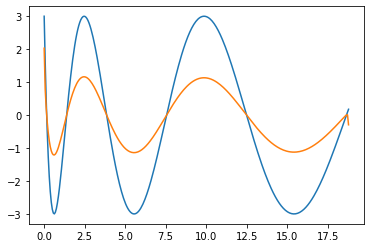

In [4]:
plt.plot(t,rawsig)
plt.plot(t,smoothed)

Now we add noise to the smoothed signal to make our fake data:

In [5]:
sn=1
data=smoothed+sn*np.random.randn(len(t))

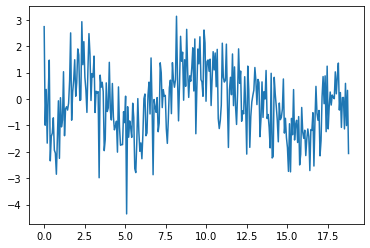

In [6]:
plt.plot(t,data)

Now we take the FFT of the data and we see the characteristic noise at all frequencies

In [7]:
datafft=fft(data)

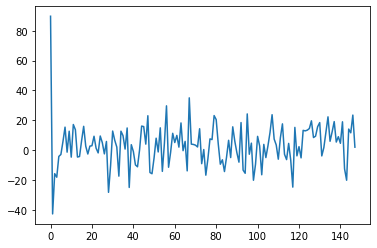

In [8]:
plt.plot(np.real(datafft[2:150]))

Now we want to invert this smoothing prodecure while accounting for the noise. We use the optimal filter

$$w = b(k)^{-1} (1+ \sigma(k)^2/|b(k)s(k)|^2)^{-1}$$

recall that for white noise $\sigma^2(\omega) = N \sigma^2$, where $N=300$ is the number of data points.

In [9]:
w=np.exp((2e-2*omega)**2)*np.abs(sfft)**2/(np.abs(sfft)**2+300*sn**2)

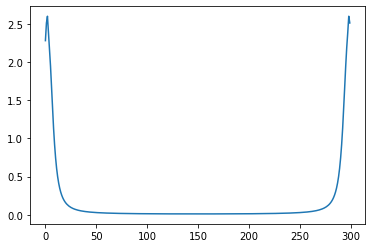

In [10]:
plt.plot(np.real(w))

Now we will apply the filter to the data to sharpen the oscilations. We will also construct the naive filter for comparison:

In [11]:
unsmooth_data=np.real(ifft(datafft*w))
unsmooth_nofilter=np.real(ifft(datafft*np.exp((2e-2*omega)**2)))

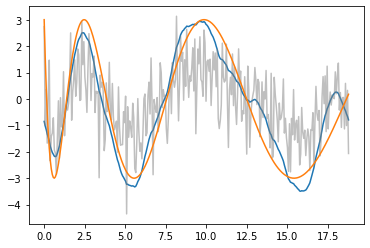

In [12]:
plt.plot(t,unsmooth_data)
plt.plot(t,data,alpha=0.5,c='grey')
plt.plot(t,rawsig)

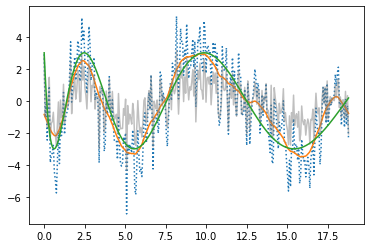

In [13]:
plt.plot(t,unsmooth_nofilter,ls=':')
plt.plot(t,unsmooth_data)
plt.plot(t,data,alpha=0.5,c='grey')
plt.plot(t,rawsig)

We see the filtered version works much better, both at following the true curve overall and minimizing the noise.

### Filtering on real images

One of the most important reasons to use a fft in more than one variable is for image processing. The reason is that most images involve a convolution between your signal of interest and something in between your signal and final measurement which blurs or distorts your signal. This could include the effect of the lens, etc.

Now we recall that convolutions in space are just products in fourier space. We we can model, or undo, any convolution using the fourier transform

In [14]:
import matplotlib.image as mpimg

img=mpimg.imread('M31.jpg')

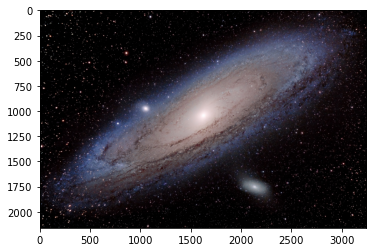

In [15]:
imgplot = plt.imshow(img)

Suppose we want to apply a filter that blurs this image according to

$$blur=\int dx' dy' \text{raw_image}(x',y') e^{-(x-x')^2 -(y-y')^2}$$

then we just take the fourier tranform

In [16]:
imgfft=fftn(img)

Now we want to multiply it by the fourier transform of the filter. First we need the k vectors

In [17]:
kx_vec = 2.0*pi*fftfreq(imgfft.shape[0])
ky_vec = 2.0*pi*fftfreq(imgfft.shape[1])
kx, ky = np.meshgrid(kx_vec,ky_vec,indexing='ij')

In [18]:
imgfft_b=imgfft.copy()

In [19]:
kx.shape

(2160, 3240)

In [20]:
for i in range(3):
    imgfft_b[:,:,i]=imgfft[:,:,i]*np.exp(-25*(kx**2+ky**2))

In [21]:
img_b_temp=ifftn(imgfft_b)
img_b=np.array(img_b_temp,dtype='uint8')

/var/folders/vh/rcz751b57355h3qzj37sc3080000gp/T/ipykernel_2548/3116491567.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  img_b=np.array(img_b_temp,dtype='uint8')


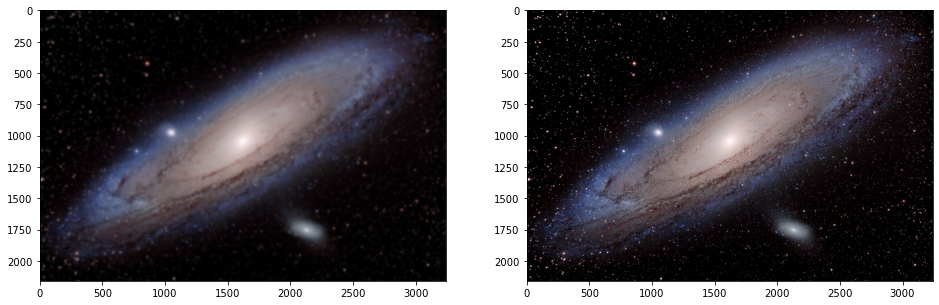

In [22]:
fig,ax=plt.subplots(figsize=(16,10),ncols=2)
ax[0].imshow(img_b)
ax[1].imshow(img)
plt.show()

We now want to save this to a file to simulate what is it like if this is out data

In [23]:
plt.imsave('M31_blur.jpeg', img_b)

We can now load the image as usual

In [24]:
m31_b=mpimg.imread('M31_blur.jpeg')

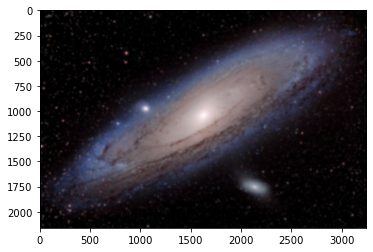

In [25]:
plt.imshow(m31_b)
plt.show()

In [26]:
m31_bfft=fftn(m31_b)

In [27]:
m31_ubfft=m31_bfft.copy()

In [28]:
for i in range(3):
    m31_ubfft[:,:,i]=m31_bfft[:,:,i]*np.exp(2*(kx**2+ky**2))

In [29]:
m31_ub=ifftn(m31_ubfft)

In [30]:
m31_ubF=np.array(m31_ub,dtype='uint8')

/var/folders/vh/rcz751b57355h3qzj37sc3080000gp/T/ipykernel_2548/2096194565.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  m31_ubF=np.array(m31_ub,dtype='uint8')


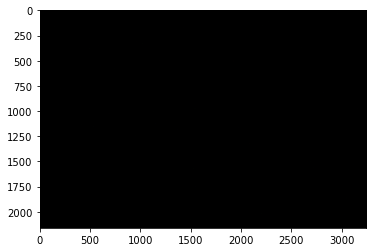

In [31]:
plt.imshow(m31_ubF)
plt.show()

To do this correctly, we need to also know the fft of the noise.

We can see the errors introduced in saving the file here:

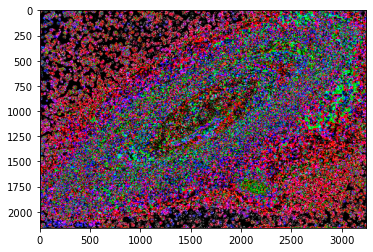

In [32]:
plt.imshow(m31_b-img_b)
plt.show()

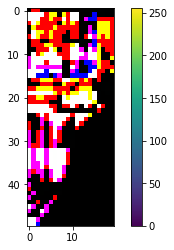

In [33]:
plt.imshow((m31_b-img_b)[0:50,0:20,:])
plt.colorbar()
plt.show()

We can see a bit of the issue here is that the way the numbers are stored means the negative numbers are large positive numbers. But, we can see from this that the error is about 1,2,3 from 0:

In [34]:
(m31_b-img_b)[0:10,0:10,0]

array([[  0, 255, 255,   1,   0,   1,   0,   1,   1,   1],
       [255, 254, 254, 254, 255, 254, 254,   0, 254, 255],
       [255, 254, 254, 255, 255, 254, 255, 255, 254, 255],
       [255, 254, 255, 255, 255, 255, 255,   0, 254, 255],
       [  0, 254, 255, 255, 255, 255, 254, 255, 255, 255],
       [  0, 254, 254, 254, 255, 254, 254, 255, 255,   0],
       [255, 254, 254, 254, 255, 254, 254, 254,   0,   0],
       [  0, 255, 255,   0,   0, 255, 255, 255,   2,   2],
       [  2, 255, 255, 254, 254, 254, 254, 255, 255, 254],
       [  2,   0, 255, 255, 255, 254, 254,   0, 255, 255]], dtype=uint8)

We can also confirm this with a histogram

(array([103.,  27.,   9.,   1.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5]),
 <BarContainer object of 4 artists>)

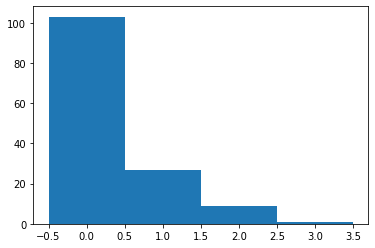

In [35]:
plt.hist(((m31_b-img_b)[0:500,0,0]),bins=[-0.5,0.5,1.5,2.5,3.5])

Let's compare this to the sizer of the bins themselves:

In [36]:
m31_b[0:10,0:10,0]

array([[45, 47, 49, 52, 52, 52, 50, 49, 46, 43],
       [47, 49, 51, 53, 54, 53, 52, 51, 47, 44],
       [49, 51, 54, 56, 57, 56, 55, 53, 49, 46],
       [51, 53, 56, 58, 59, 58, 57, 56, 51, 48],
       [52, 54, 57, 59, 60, 59, 57, 56, 53, 49],
       [52, 53, 56, 58, 59, 58, 57, 56, 53, 50],
       [50, 52, 55, 57, 58, 57, 56, 54, 53, 49],
       [49, 51, 54, 56, 57, 56, 55, 53, 53, 49],
       [48, 49, 51, 52, 52, 52, 51, 50, 47, 43],
       [45, 46, 47, 49, 49, 48, 47, 47, 44, 41]], dtype=uint8)

In [37]:
m31_b.shape

(2160, 3240, 3)

In [38]:
NN=2160*3240*3

So the typically size of noise / signal = 3/50. Now remembering our optimal filter is defined so that is our blurred image is blurrer = $b$ raw + $n$, where $n$ 

$$w = b(k)^{-1} (1+ \sigma(k)^2/|b(k)s(k)|^2)^{-1}$$

Now comes the practice problem with this formula: we don't actually have a good handle on $\sigma(k)$ because we haven't actually understood the noise very well. So we will simply intepret $\sigma^2 / (b(k) s(k))^2$ as the average signal to noise of our maps and just use that as a $k$-independent number. We can write this as

In [39]:
w=np.exp(-25*(kx**2+ky**2))/(np.exp(-50*(kx**2+ky**2))+1e-2)

In [40]:
print(w.shape)
m31_bfft.shape

(2160, 3240)


(2160, 3240, 3)

In [41]:
for i in range(3):
    m31_ubfft[:,:,i]=m31_bfft[:,:,i]*w


In [42]:
m31_ub=ifftn(m31_ubfft)

In [43]:
m31_ubF=np.array(m31_ub,dtype='uint8')

/var/folders/vh/rcz751b57355h3qzj37sc3080000gp/T/ipykernel_2548/2096194565.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  m31_ubF=np.array(m31_ub,dtype='uint8')


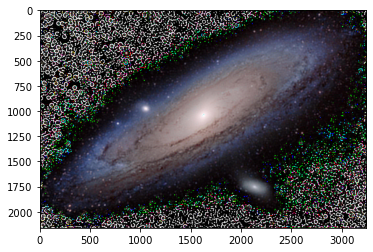

In [44]:
plt.imshow(m31_ubF)
plt.show()

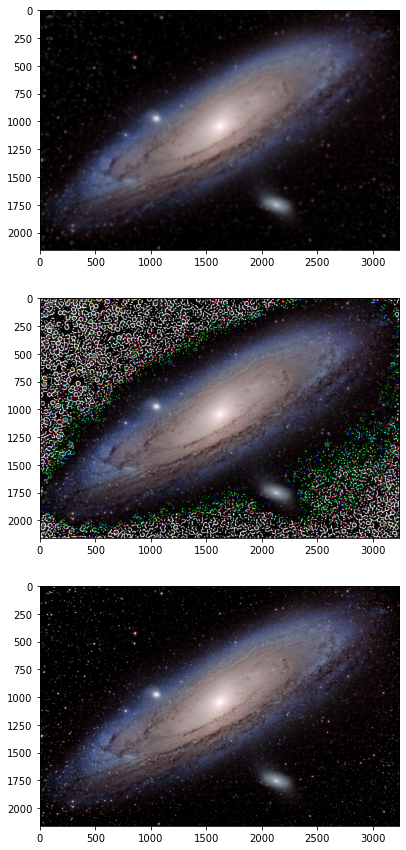

In [45]:
fig,ax=plt.subplots(figsize=(30,15),nrows=3)
ax[0].imshow(img_b)
ax[1].imshow(m31_ubF)
ax[2].imshow(img)
plt.show()

### Comparison with filter assuming white noise:

In our first attempt, rather than using the optimal fiter, we simply estimated that the signal to noise was a constant. 

In [46]:
m31_bfft2=np.zeros(m31_b.shape,dtype='complex')
for i in range(3):
    m31_bfft2[:,:,i]=fftn(m31_b[:,:,i])

In [47]:
m31_bfft2.shape

(2160, 3240, 3)

In [48]:
nb=2160*3240

In [49]:
ubm31fft2=np.zeros(m31_b.shape,dtype='complex')
for i in range(3):
    w2=np.exp(25*(kx**2+ky**2))*np.abs(imgfft_b[:,:,i])**2/(np.abs(imgfft_b[:,:,i])**2+nb)
    ubm31fft2[:,:,i]=fftn(m31_b[:,:,i])*w2

In [50]:
m31_ub2=np.zeros(m31_b.shape,dtype='complex')
for i in range(3):
    m31_ub2[:,:,i]=ifftn(ubm31fft2[:,:,i])

In [51]:
m31_ubF2=np.array(m31_ub2,dtype='uint8')

/var/folders/vh/rcz751b57355h3qzj37sc3080000gp/T/ipykernel_2548/1155444789.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  m31_ubF2=np.array(m31_ub2,dtype='uint8')


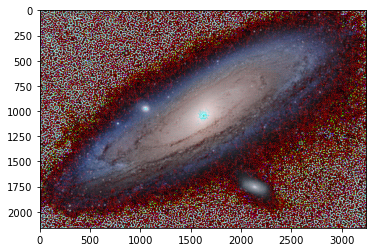

In [52]:
plt.imshow(m31_ubF2)
plt.show()